<a href="https://colab.research.google.com/github/sushilyadav9713/names/blob/main/indianmalenamegenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/sushilyadav9713/names/refs/heads/main/output_file.txt

--2025-03-29 14:36:59--  https://raw.githubusercontent.com/sushilyadav9713/names/refs/heads/main/output_file.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175713 (172K) [text/plain]
Saving to: ‘output_file.txt’

output_file.txt     100%[===================>] 171.59K  --.-KB/s    in 0.1s    

2025-03-29 14:37:00 (1.17 MB/s) - ‘output_file.txt’ saved [175713/175713]



In [ ]:
words = open('output_file.txt', 'r').read().splitlines()
words[:8]

['baljraj',
 'ramdin verma',
 'sharat chandran',
 'birender mandal',
 'amit',
 'kushal',
 'kasid',
 'shiv prakash']

In [ ]:
len(words)

14790

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([128695, 3]) torch.Size([128695])
torch.Size([16059, 3]) torch.Size([16059])
torch.Size([16171, 3]) torch.Size([16171])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((29, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 29), generator=g)
b2 = torch.randn(29, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

12319

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

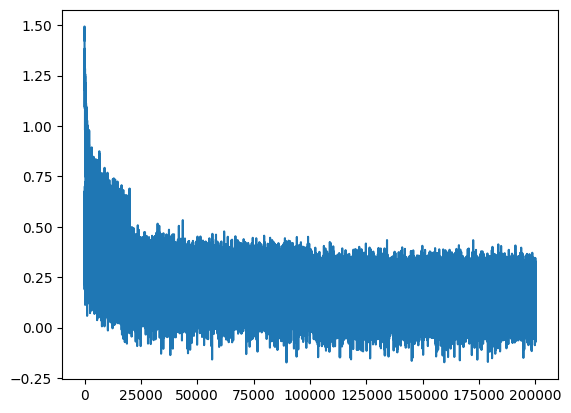

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.4773, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.5538, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.5758, grad_fn=<NllLossBackward0>)

KeyError: 28

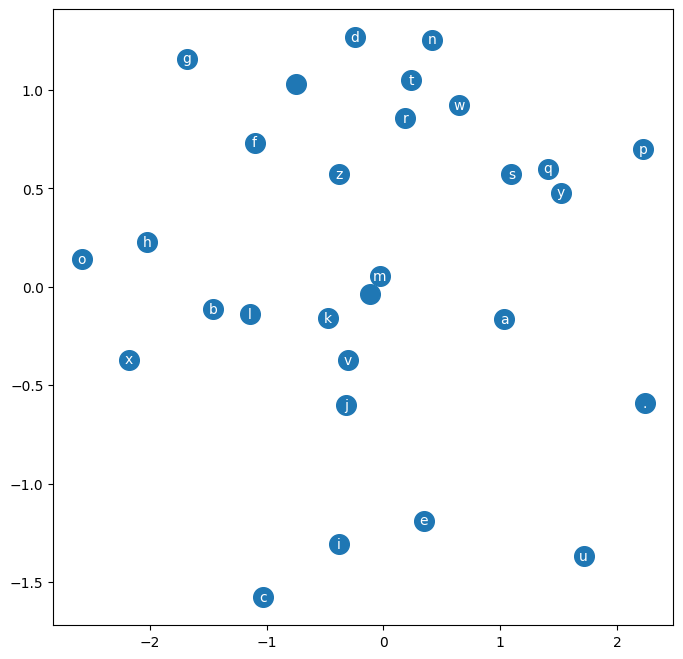

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(214748364)

for _ in range(5001):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

Streaming output truncated to the last 5000 lines.
devender singh.
shi .
sundir.
jai run.
divar.
ary.
sanju.
ajid wari.
deep kumar.
sakesh.
puneer singh.
shar.
deep.
taran sisra.
sonu kumar.
vike.
vikraj kumar kumar.
kdy shand.
jasbon.
mr chand mohd iladav.
vin kumar singh.
pankarana shanku veenrosavd kap singh.
mudesh kumar jugal singh yadav.
mahar lallu.
ymadav.
md pranjlekram khand.
jam.
gegni.
gaura lal ahmamitlal.
ardeep kumar.
amit  maheeda singh  goyasalim.
harma.
man.
jit.
akram.
rajender  babul kandu.
hari.
adiliya.
nirma.
aabir hurender.
neer.
deepchawat.
avishari.
kapil.
suanwar.
rosa  raju.
rahul.
ram.
vish kumar kumar.
raghavan.
vashok khawlakhock goehjaveeram n.
sonuar jain.
man.
murledesh.
vidishan sunil kumar.
jamurli  monu dholu.
anishahib lal.
mwamit n.
jan.
rakas bib.
amar.
laxman.
harma  boobanshahyam lal.
mohd gupta.
shrayan vakashishander kumar.
gulam vatekh ahola.
hal dhay.
jiteshan lal.
netrilal.
guddu puanwaribansu.
deep kumar.
sunni  kant man singh  hambir.
sa